In [5]:
import pandas as pd
import numpy as np
from simulator import conduct_simulation

# Experiments

# Input data processing
df = pd.read_table('haberman.data', header=None)
raw_data = np.array(df)
pro_data = [[],[]]
for item in raw_data:
    pro_item = str(item[0]).split(',')
    pro_item = [eval(pro_item[0]),eval(pro_item[1]),eval(pro_item[2]),pro_item[3]]
    if pro_item[3] == '1':    
        pro_item[3] = 0
        pro_data[0].append(pro_item)
    if pro_item[3] == '2': 
        pro_item[3] = 1
        pro_data[1].append(pro_item)

# Components for GMM model
components_num = 3

# Proportion of training and test sets
train_ratio_list = np.array([0.3,0.4,0.5,0.6,0.7,0.8,0.9])

# Monte Carlo experiments num
N = 100

# Simulation
mean_accuracy_classical, mean_accuracy_quantum_32, mean_accuracy_quantum_1024 = conduct_simulation(pro_data, train_ratio_list, components_num, N)

Train Ratio: 0.3
Iteration number: 0
Iteration number: 10
Iteration number: 20


Text(0.5, 1.0, 'Haberman Data Set')

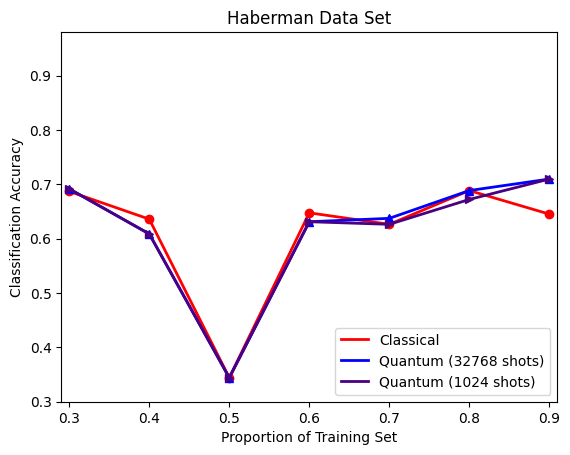

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure()
# plt.grid(color='gray', linestyle='-', linewidth=0.5)
ax1 = fig.add_subplot(111)
lns1 = ax1.plot(train_ratio_list, mean_accuracy_classical, 'r', linewidth = 2.0, label = 'Classical')
ax1.plot(train_ratio_list, mean_accuracy_classical,'o',color = 'r')
lns2 = ax1.plot(train_ratio_list, mean_accuracy_quantum_32, 'b', linewidth = 2.0, label = 'Quantum (32768 shots)')
ax1.plot(train_ratio_list, mean_accuracy_quantum_32,'b^')
lns3 = ax1.plot(train_ratio_list, mean_accuracy_quantum_1024, 'indigo', linewidth = 2.0, label = 'Quantum (1024 shots)')
ax1.plot(train_ratio_list, mean_accuracy_quantum_1024,'>', color = 'indigo')

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='lower right')
ax1.set_xlim(0.29,0.91)
ax1.set_ylim(0.3, 0.98)
ax1.set_ylabel("Classification Accuracy")
ax1.set_xlabel("Proportion of Training Set")
plt.title("Haberman Data Set")
# plt.savefig("Iris.pdf", dpi=400)

In [22]:
# Experiments


# Input data processing
df = pd.read_table('haberman.data', header=None)
raw_data = np.array(df)
pro_data = [[],[]]
for item in raw_data:
    pro_item = str(item[0]).split(',')
    pro_item = [eval(pro_item[0]),eval(pro_item[1]),eval(pro_item[2]),pro_item[3]]
    if pro_item[3] == '1':    
        pro_item[3] = 0
        pro_data[0].append(pro_item)
    if pro_item[3] == '2': 
        pro_item[3] = 1
        pro_data[1].append(pro_item)

components_num = 3
train_ratio_list = np.array([0.3,0.4,0.5,0.6,0.7,0.8,0.9])

mean_accuracy_quantum_32 = np.empty_like(train_ratio_list)
mean_accuracy_quantum_1024 = np.empty_like(train_ratio_list)
mean_accuracy_classical = np.empty_like(train_ratio_list)

for k in range(len(train_ratio_list)):
    train_ratio = train_ratio_list[k]
    print("Train Ratio: "+ str(train_ratio))

    m = 3 # attribute
    n = 2 # types

    # Monte Carlo experiments 
    N = 100

    accuracy_record_quantum_32 = np.zeros(N)
    accuracy_record_quantum_1024 = np.zeros(N)
    accuracy_record_classical = np.zeros(N)

    for iternum in range(N):
        if iternum % 10 == 0:
            print("Iteration number: "+str(iternum))
        # print(train_ratio, iternum)
        # save training and testing data
        training_set = [[[] for col in range(m)] for row in range(n)]
        testing_set = [[] for row in range(n)]
        # for each type
        for ii in range(n):
            x = train_test(np.array(pro_data[ii]),train_ratio)
            testing_set[ii] = x[1][:,0:3]
        #     for each attribute
            for jj in range(m):
                training_set[ii][jj] = x[0][:,jj]


        testing_num = 0
        error_num_quantum_32 = 0
        error_num_quantum_1024 = 0
        error_num_classical = 0

        types_num = len(testing_set)

        weights, means, covariances = learn_GMM_coefficients(training_set, components_num)
        
        for ii in range(types_num):
            testing_num += len(testing_set[ii])
            for testing_data in testing_set[ii]:
                BPA, alphas = generate_BPAs(testing_data, weights, means, covariances)
            
                # quantum: 32 shots
                combined_BPA_quantum_32 = combineBPAs_quantum(alphas, 32)
                classification_result_quantum_32 = decision_making(combined_BPA_quantum_32)
                if  classification_result_quantum_32 != ii:
                    error_num_quantum_32 += 1

                # quantum: 1024 shots
                combined_BPA_quantum_1024 = combineBPAs_quantum(alphas, 1024)
                classification_result_quantum_1024 = decision_making(combined_BPA_quantum_1024)
                if  classification_result_quantum_1024 != ii:
                    error_num_quantum_1024 += 1
                
                # classical
                combined_BPA_classical = combine_BPAS_classical(BPA)
                classification_result_classical = decision_making(combined_BPA_classical)
                if  classification_result_classical != ii:
                    error_num_classical += 1
                
        accuracy_record_quantum_32[iternum] = 1 - error_num_quantum_32/testing_num
        accuracy_record_quantum_1024[iternum] = 1 - error_num_quantum_1024/testing_num
        accuracy_record_classical[iternum] = 1 - error_num_classical/testing_num

    mean_accuracy_quantum_32[k] = np.mean(accuracy_record_quantum_32)
    mean_accuracy_quantum_1024[k] = np.mean(accuracy_record_quantum_1024)
    mean_accuracy_classical[k] = np.mean(accuracy_record_classical)

Train Ratio: 0.3
Iteration number: 0
Iteration number: 10
Iteration number: 20


Text(0.5, 1.0, 'Iris Data Set')

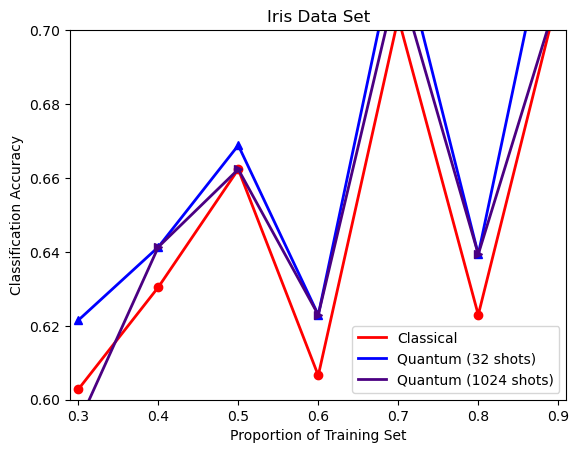

In [19]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
lns1 = ax1.plot(train_ratio_list, mean_accuracy_classical, 'r', linewidth = 2.0, label = 'Classical')
ax1.plot(train_ratio_list, mean_accuracy_classical,'o',color = 'r')
lns2 = ax1.plot(train_ratio_list, mean_accuracy_quantum_32, 'b', linewidth = 2.0, label = 'Quantum (32 shots)')
ax1.plot(train_ratio_list, mean_accuracy_quantum_32,'b^')
lns3 = ax1.plot(train_ratio_list, mean_accuracy_quantum_1024, 'indigo', linewidth = 2.0, label = 'Quantum (1024 shots)')
ax1.plot(train_ratio_list, mean_accuracy_quantum_1024,'>', color = 'indigo')

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='lower right')
ax1.set_xlim(0.29,0.91)
ax1.set_ylim(0.6,0.7)
ax1.set_ylabel("Classification Accuracy")
ax1.set_xlabel("Proportion of Training Set")
plt.title('Iris Data Set')
# plt.savefig('iris.pdf', dpi=400)